In [2]:
import subprocess as sb
from pathlib import Path

import pysam
import pandas as pd
import numpy as np
import seaborn.objects as so
from seaborn import axes_style
from IPython.display import display
Path.cwd()

PosixPath('/project/cs-myers/MathewF/projects/Laura-SB-Analysis/NetCIS/notebooks')

In [3]:
def file_stats(file):
    # get file name attributes
    tumor_model, sample_id, tumor_tmp = file.name.split("-")
    tissue_type, lib_tmp = tumor_tmp.split("_")
    library, file_type = lib_tmp.split(".")
    tmp = {"file": file_type, "tumor_model": tumor_model, "sample_id": sample_id, "tissue_type": tissue_type, "library": library}

    # get file mapping stats
    output = sb.check_output(f"samtools stats {file} | grep ^SN | cut -f 2-", shell=True).decode('UTF-8')
    output = output.strip().split("\n")
    for x in output:
        key, value = x.strip().split(":")
        tmp[key] = float(value.strip().split("#")[0].strip())
    df = pd.DataFrame.from_dict(tmp, orient="index").T
    return df

def mapper_count_reads(bam_dir, in_file, mapper_name):
    # get stats for each sample: mapped but unfiltered sam files IRL/IRR and filtered bam files IRL/IRR
    files_df = pd.read_csv(in_file, sep="\t", header=None)
    reads_list = []
    for row in files_df.iterrows():
        mysample = row[1][0]
        reads_list.append(file_stats(bam_dir / (mysample + "_IRL.sam")))
        reads_list.append(file_stats(bam_dir / (mysample + "_IRL.bam")))
        reads_list.append(file_stats(bam_dir / (mysample + "_IRR.sam")))
        reads_list.append(file_stats(bam_dir / (mysample + "_IRR.bam")))
        
    reads_df = pd.concat(reads_list, axis=0).reset_index(drop=True)
    reads_df["mapper"] = mapper_name
    return reads_df

In [4]:
input_file = Path("/project/cs-myers/MathewF/projects/Laura-SB-Analysis/input.tsv")
bam_files = Path("/project/cs-myers/MathewF/projects/Laura-SB-Analysis/output/2020_SB-bam/")

In [5]:
read_files_df = mapper_count_reads(bam_files, input_file, "bowtie-local")
# read_files_df.to_csv(output_dir / "bowtie2_local-read_counts.csv")

In [6]:
data = read_files_df
data.columns = [ str(col).replace(" ", "_") for col in data.columns ]
display(data)

,file,tumor_model,sample_id,tissue_type,library,raw_total_sequences,filtered_sequences,sequences,is_sorted,1st_fragments,...,maximum_last_fragment_length,average_quality,insert_size_average,insert_size_standard_deviation,inward_oriented_pairs,outward_oriented_pairs,pairs_with_other_orientation,pairs_on_different_chromosomes,percentage_of_properly_paired_reads_(%),mapper
0,sam,EL4,18_2,LT,IRL,40046.0,0.0,40046.0,0.0,20018.0,...,148.0,38.4,202.5,91.6,886.0,60.0,0.0,1.0,4.6,bowtie-local
1,bam,EL4,18_2,LT,IRL,966.0,0.0,966.0,1.0,483.0,...,148.0,36.4,187.5,70.3,465.0,18.0,0.0,0.0,100.0,bowtie-local
2,sam,EL4,18_2,LT,IRR,19916.0,0.0,19916.0,0.0,9951.0,...,148.0,37.6,205.0,73.1,2206.0,391.0,1.0,15.0,25.6,bowtie-local
3,bam,EL4,18_2,LT,IRR,4558.0,0.0,4558.0,1.0,2279.0,...,148.0,36.8,203.8,65.3,1937.0,342.0,0.0,0.0,100.0,bowtie-local
4,sam,EL4,18_2,RT,IRL,50309.0,0.0,50309.0,0.0,25147.0,...,148.0,38.5,216.9,97.6,511.0,48.0,0.0,0.0,2.2,bowtie-local
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,bam,LLC,168_1,RT,IRR,2.0,0.0,2.0,1.0,1.0,...,148.0,36.5,194.0,0.0,1.0,0.0,0.0,0.0,100.0,bowtie-local
1244,sam,LLC,174_1,LT,IRL,61139.0,0.0,61139.0,0.0,30566.0,...,148.0,39.1,149.8,8.3,41.0,35.0,0.0,0.0,0.2,bowtie-local
1245,bam,LLC,174_1,LT,IRL,112.0,0.0,112.0,1.0,56.0,...,148.0,38.8,148.6,2.5,37.0,19.0,0.0,0.0,100.0,bowtie-local
1246,sam,LLC,174_1,LT,IRR,39142.0,0.0,39142.0,0.0,15769.0,...,148.0,39.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bowtie-local


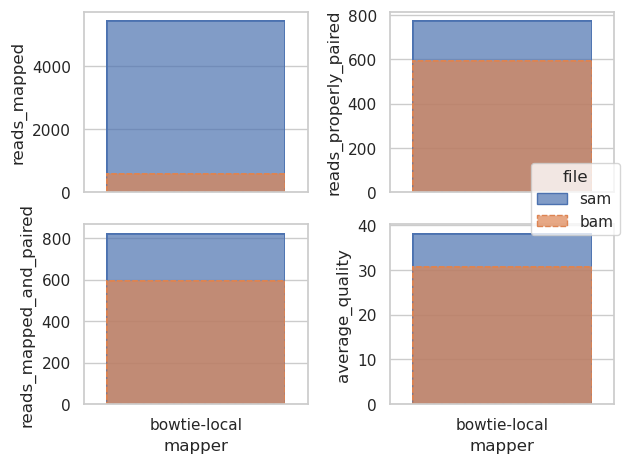

596.8012820512821

In [8]:
cols = ["reads_mapped",
        "reads_mapped_and_paired",
        "reads_properly_paired",
        "average_quality",
        ]
g = (
    so.Plot(data, x="mapper", color="file", edgestyle="file")
    .add(so.Bar(), so.Agg())
    # .add(so.Range(), so.Est(errorbar="sd"), so.Dodge())
    .pair(wrap=2, y=cols)
    # .layout(size=(10,6))
    .theme({**axes_style("whitegrid")})
)
g.show()
data[(data["mapper"] == "bowtie-local") & (data["file"] == "bam")]["reads_properly_paired"].mean()